In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 1 A Notch Digital Filter (4 marks, 2/1/1)

A notch filter is a filter that passes almost all frequencies with unit amplitude, except for a narrow
range of frequencies centered on the rejection frequency $f_0$ (at which frequency nothing is passed).

A simple notch digital filter has a z-transform

$$ W(z) = MF(z) F(z^*)^* = M \frac{z - q}{z - p} \frac{z - q^*}{z - p^*} $$

where $M$ is a normalization factor, $q = e^{-i 2 \pi f_0 / f_s}$, $p = (1 + \epsilon) q$, $f_s$ 
is the sampling rate ($f_s = 1 / \Delta$) and $\epsilon$ is a small positive number ($0 < \epsilon \ll 1$).

 1. What are the poles and zeros of this system? Where are they located with respect to the unit
    circle? Is this a stable system? Is this filter real?
 2. Given $f_s = 12 \text{ cycles/year}$, $f_0 = 1 \text{ cycle/year}$, $M = 1.04$ and $\epsilon = 0.04$, plot the
    power spectrum $|W(f)|^2=W(f)W(f)^\ast$ (i.e., square of amplitude spectrum). Sample densely in $[-f_s/2, \ldots, f_s/2]$ (e.g. 1000 points), where $f_s/2$ is the Nyquist frequency.
 3. What is the full-width-half-max (FWHM) value $f_\text{fwhm}$ of this notch filter (based on the plot)? Which parameter(s) should you change to make the notches sharper, i.e., $f_\text{fwhm}$ smaller?

_Hint_: For question 1.1, a filter is "real" if a real input timeseries passed through the filter remains real (see question 2.2). Completing question 2.1 first may be helpful to prove this.

_Hint_: For question 1.2, $W(f)$ is obtained by $W(z = e^{-i \omega \Delta}$). For question 3, you don't have to
compute the FWHM value analytically (although it can be done); an inspection of the discrete array of $|W(f)|^2$
values is sufficient. Note here $f_\text{fwhm}$ is in terms of frequency (1/year), not angular frequency.

# 1.1

The system has zeroes at z=q & q\* and poles at z = p and p\*. With respect to the unit circle, q and q\* are on the unit circle at an angle of +/-w0 (2pif0) and p and p\* are just outside the unit circle, at the same angle. This filter is real since it includes the multiplication by its complex conjugate, so the output will be real for real input (see slide 17 from the lectures). From 2.1 we see that it can be implemented as a filter with a 3 term real time series and an inverse filter of a 3 term real time series, which is why it is real. It is also stable, as the region within the poles contains the unit circle so that is the region of convergence (the series doesn't go to infinity).


# 1.2

C:\Users\Juan\Anaconda2\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


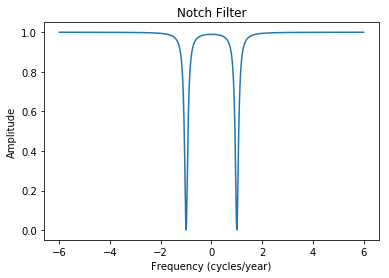

In [2]:
fs = 12.0  # cycles/year
f0 = 1.0  # cycle/year
dt = 1./fs  # years/cycle
M = 1.04
epsilon = 0.04

q = np.exp(-1j*2*np.pi*f0/fs)
p = (1 + epsilon)*q
qstar = np.conj(q)
pstar = np.conj(p)

f = np.linspace(-fs/2,fs/2,1000)
z = np.exp(-1j*2*np.pi*dt*f)


W = M*((z-q)/(z-p))*((z-qstar)/(z-pstar))

WReal, WIm, WAbs = np.real(W), np.imag(W), np.abs(W)
#plt.plot(f,WAbs)

plt.plot(f, np.conj(W)*W)
plt.title("Notch Filter")
plt.xlabel("Frequency (cycles/year)")
plt.ylabel("Amplitude")
plt.show()

# 1.3

As seen from the plot below, the FWHM is about 0.15 (units cycles/year). Decreasing epsillon (ie. placing p closer to the unit circle) will make the notches sharper, though the value of M must be modified accordingly to ensure normalization.

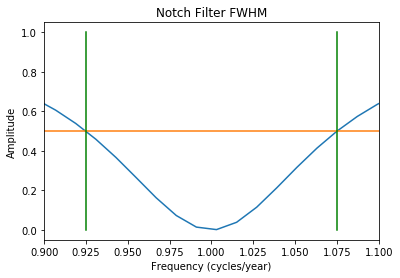

In [3]:
plt.plot(f, np.conj(W)*W)
plt.plot(f, 0.5*np.ones(len(f)))
plt.plot(1.075*np.ones(100), np.linspace(0,1,100), 'g')
plt.plot(0.925*np.ones(100), np.linspace(0,1,100), 'g')
plt.xlim(0.9,1.1)
plt.title("Notch Filter FWHM")
plt.xlabel("Frequency (cycles/year)")
plt.ylabel("Amplitude")
plt.show()

# 2 Implementing the Notch Filter (5 marks, 1/2/1/1)

Notch filter introduced in section 1 can be written out fully as

$$ W(z) = \frac{N(z)}{D(z)} = \frac{a + bz + cz^2}{1 + Bz + Cz^2} $$

A filter of the form above can be implemented as two filters in succession: first the 'numerator filter'
`[a b c]` as a 3-term direct convolution, then the 'denominator filter' as the inverse filter of the 3-term
filter `[1 B C]` by feedback filtering.

 1. What are the values of a; b; c; B; C for the notch filter defined in question 1.2?
 2. Write a function for a general rational digital filter with numerator and denominator
    coefficients N and D which produces the filtered time series $y$ for a given input $x$,
    `y = ratFilter(N,D,x)`.
 3. Use `ratFilter` function to determine the impulse response of this notch filter (i.e., the output
    of this filter when the input is a discrete delta function). Define the impulse using $dt=1/f_s$ and $t=0$ to $t_{max}=100$ years (i.e. $1200$ samples). Plot the impulse response from $0$ to $6$ years. Speculate on how the impulse response would change if we halve the $f_\text{fwmh}$ value.
 4. Fourier transform the impulse response to obtain the frequency response $|W(f)|$
    of this notch filter. Plot it on top of the magnitude of the theoretical spectrum calculated based on the z-transform, with $f$ ranging from $0$ to $6$ cycles per year.

# 2.1

see pdf

# 2.2 & 2.3

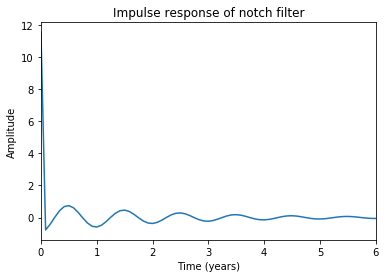

In [5]:
def ratFilter(N, D, x):
    
    # apply convolution with numerator filter:
    x = np.convolve(N, x, 'full')
    
    # Feedback filtering:
    y = np.zeros(len(x)-2)
    
    for i in range(len(x)-2):
        #print(i)
        y[i] = x[i]/D[0]
        
        for k in range(1, len(D)):
            if i-k < 0:
                break
            y[i] = y[i] - D[k]*y[i-k]/D[0]
    
    return y

dt = 1./fs
t = np.arange(0, 100, dt)
impulse = np.zeros(len(t))
impulse[0] = 1/dt

# notch filter values:
a = M/((1 + epsilon)**2)
b = -2*M*np.cos(2*np.pi*f0/fs)/((1 + epsilon)**2)
c = a
B = -2*np.cos(2*np.pi*f0/fs)/(1 + epsilon)
C = a/M

N = np.array([a, b, c])
D = np.array([1, B, C])


# ratFilter
impulseResponse = ratFilter(N, D, impulse)


# plotting:
plt.plot(t, impulseResponse)
plt.xlim([0,6])
plt.title("Impulse response of notch filter")
plt.ylabel("Amplitude")
plt.xlabel("Time (years)")
plt.show()

# 2.3

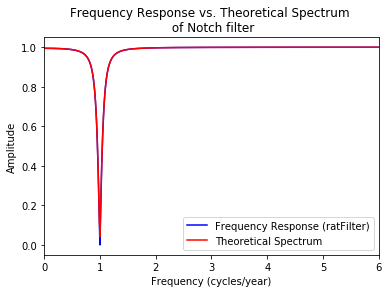

In [6]:
# fast fourier transforms
freqResponse = np.fft.fft(impulseResponse)*dt

freqResponse_abs = np.fft.fftshift(np.abs(freqResponse))

# frequency axis:
f2 = np.fft.fftshift(np.fft.fftfreq(len(impulseResponse), dt))

plt.plot(f2, freqResponse_abs, 'b', label='Frequency Response (ratFilter)')
plt.plot(f, WAbs, 'r', label="Theoretical Spectrum")
plt.xlim([0,6])
plt.title("Frequency Response vs. Theoretical Spectrum \n of Notch filter")
plt.xlabel("Frequency (cycles/year)")
plt.ylabel("Amplitude")
plt.legend(loc="lower right")
plt.show()



# 3 The Mauna Loa $CO_2$ Data (6 marks, 1/1/1/1/2)

The provided file `co2data.py` contains carbon dioxide values (in parts per million) measured
every month at the Mauna Loa Observatory in Hawaii, from January 1965 to December 2003.
They show clearly a rising trend in atmospheric $CO_2$. The trend is overlaid with a strong annual
oscillation. Your job is to remove the annual oscillation and display the trend more clearly. There
are two possible approaches: (a) you could apply your notch filter to the series to remove this
annual variation, or (b) you could Fourier transform it with `fft`, remove the annual variation by
setting the spectrum at appropriate frequencies to zero, and transform back to the time domain with
`ifft`.

Write code to accomplish the following:

 1. Before applying the filters, it is helpful to remove the trend of the signal using numpy
    function `polyfit`. Fit a straight line to your data and then detrend your data by removing the
    straight line. Plot both the original data and the detrended data.
 2. Apply your notch filter to the detrended data and add back the trend.
 3. FT the detrended data into the frequency domain, and plot both its amplitude and phase
    spectrum. Make another plot that zooms in at $f = [0, 3.5]$ cycles per year. Now set the
    Fourier spectrum corresponding to frequencies beyond $0.9$ cycles per year to zero (keeping in mind symmetry requirements), which
    effectively removes the annual oscillation. Transform the spectrum back to time domain and
    add back the trend.
 4. Now plot the original data, the notch-filtered data from part 2 and f-domain filtered data
    from part 3 on top of each other with different colors. Which method gives more satisfactory
    result? But can you think of any advantages/disadvantages in using either method?
 5. Now try redo part 2, 3, and 4 with the original data, not the detrended data. Of course you
    don't need to add back the trend after filtering any more. Display your results and comment
    on the importance of detrending before applying the filters.
    

# 3.1

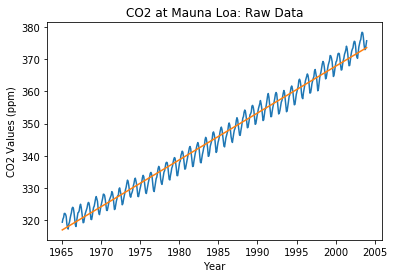

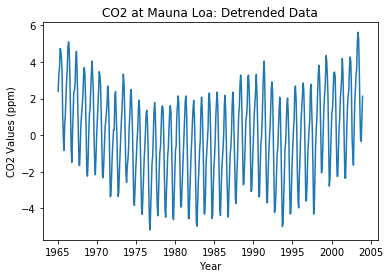

[1965.0417     1965.12503319 1965.20836638 1965.29169957]


In [3]:
# import data
from co2data import co2Data, co2TimeRange

# time
t = np.linspace(co2TimeRange[0], co2TimeRange[1], len(co2Data)) 

# get trendline
m, b = np.polyfit(t, co2Data, 1)
trend = m*t + b

plt.plot(t, co2Data)
plt.plot(t, trend)
plt.title("CO2 at Mauna Loa: Raw Data")
plt.xlabel("Year")
plt.ylabel("CO2 Values (ppm)")
plt.show()

# remove trendline
data = co2Data-trend
plt.plot(t, data)
plt.title("CO2 at Mauna Loa: Detrended Data")
plt.xlabel("Year")
plt.ylabel("CO2 Values (ppm)")
plt.show()


# 3.2

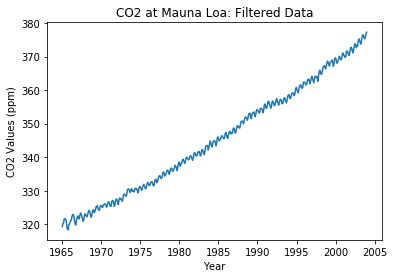

In [75]:
filtered_data = ratFilter(N, D, data) +trend
plt.plot(t, filtered_data)
plt.title("CO2 at Mauna Loa: Filtered Data")
plt.xlabel("Year")
plt.ylabel("CO2 Values (ppm)")
plt.show()


# 3.3

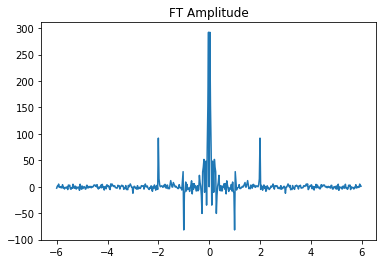

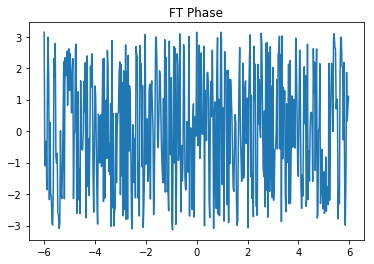

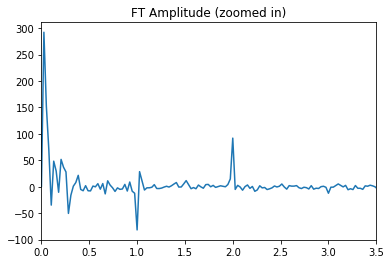

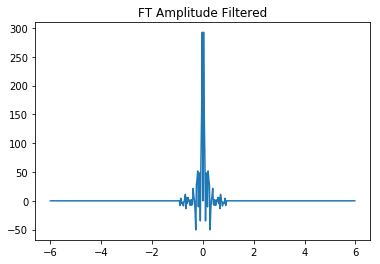

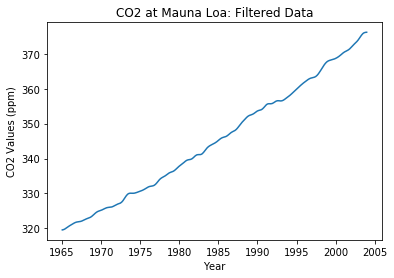

In [100]:
dt = t[1]-t[0]


# fast fourier transforms
FT = np.fft.fftshift(np.fft.fft(data))

FT_phase = np.angle(FT)


# frequency axis:
freq = np.fft.fftshift(np.fft.fftfreq(len(data), dt))

plt.plot(freq, FT)
plt.title("FT Amplitude")
plt.show()


plt.plot(freq, FT_phase)
plt.title("FT Phase")
plt.show()

plt.plot(freq, FT)
plt.title("FT Amplitude (zoomed in)")
plt.xlim([0,3.5])
plt.show()

FT_filtered = np.where(np.abs(freq)>0.9, 0, FT)
plt.plot(freq, FT_filtered)
plt.title("FT Amplitude Filtered")
plt.show()


# go back to time domain and add back trendline
filtered_data_2 = np.fft.ifft(np.fft.ifftshift(FT_filtered)) + trend
plt.plot(t, filtered_data_2)
plt.title("CO2 at Mauna Loa: Filtered Data")
plt.xlabel("Year")
plt.ylabel("CO2 Values (ppm)")
plt.show()

# 3.4

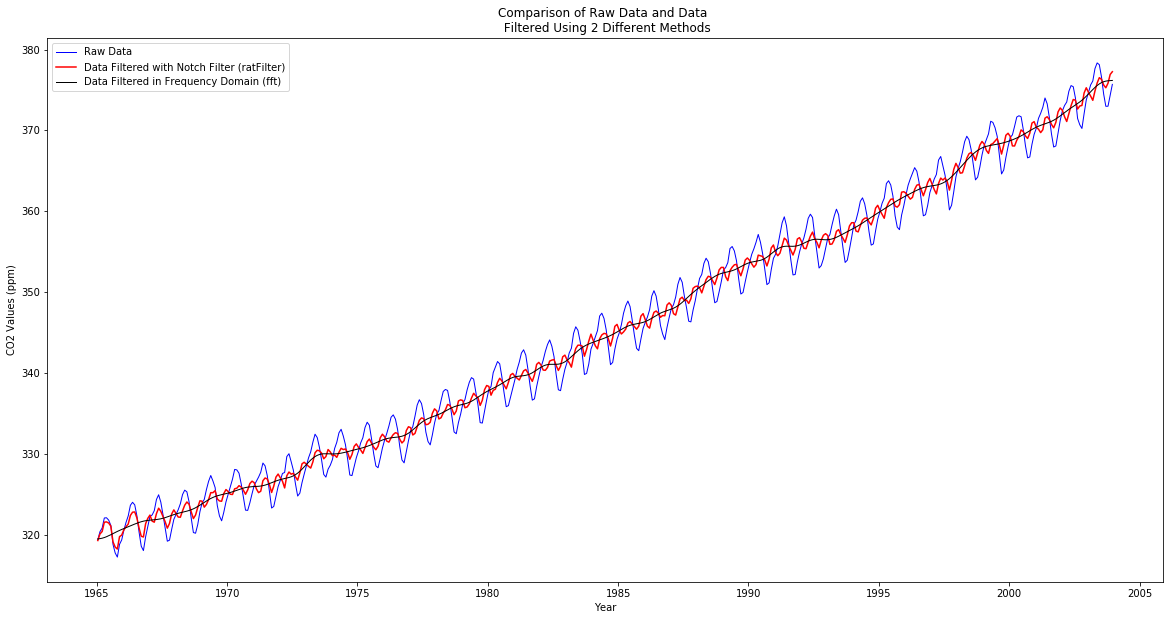

In [96]:
plt.figure(figsize=(20,10))
plt.plot(t, co2Data, 'b', label="Raw Data", linewidth=1)
plt.plot(t, filtered_data, 'r', label="Data Filtered with Notch Filter (ratFilter)")
plt.plot(t, filtered_data_2, 'black', label="Data Filtered in Frequency Domain (fft)", linewidth=1)
plt.title("Comparison of Raw Data and Data \n Filtered Using 2 Different Methods")
plt.xlabel("Year")
plt.ylabel("CO2 Values (ppm)")
plt.legend(loc="upper left")


plt.show()

The fourier transform method seems to give more satisfactory results, since we get a smoother curve. One downside of this method though, is that we are removing information about high frequency fluctuations (cycles shorter than a year), not just the yearly fluctuations (although you could just remove frequencies close to 1 cycle/year (say, between 0.9 and 1.1) instead of all those higher than 0.9 to get rid of this problem). But as a visualization of the long term trend, the fourier transform method seems to be better.

# 3.5

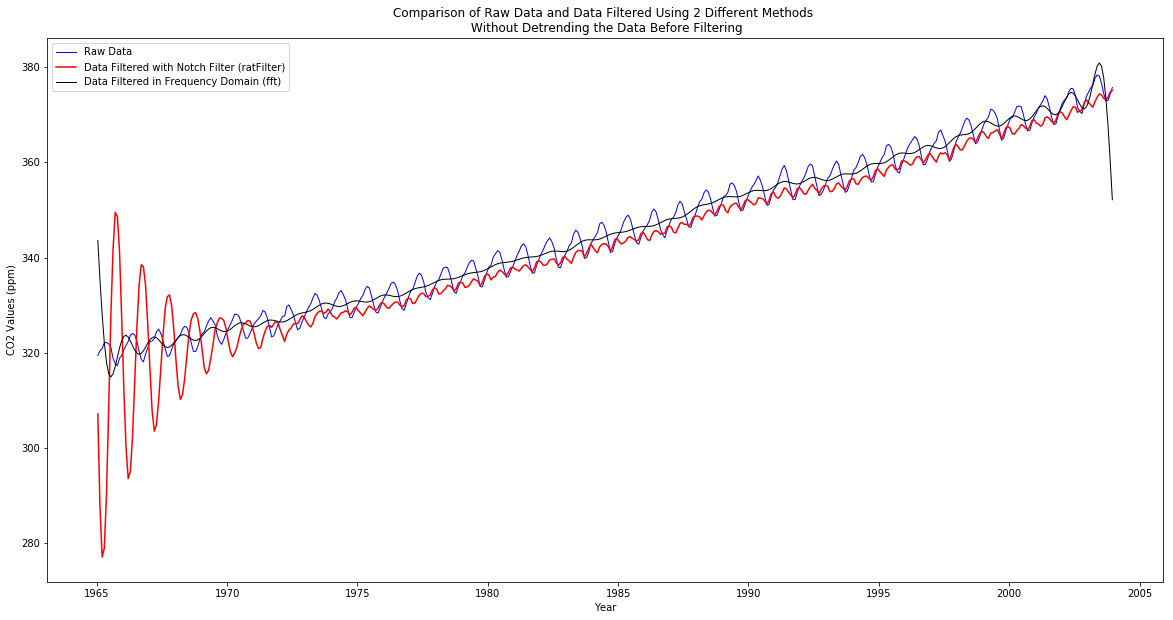

In [105]:
filtered_data = ratFilter(N, D, co2Data)

# fast fourier transforms
FT = np.fft.fftshift(np.fft.fft(co2Data))

FT_phase = np.angle(FT)


# frequency axis:
freq = np.fft.fftshift(np.fft.fftfreq(len(co2Data), dt))

FT_filtered = np.where(np.abs(freq)>0.9, 0, FT)


# go back to time domain
filtered_data_2 = np.fft.ifft(np.fft.ifftshift(FT_filtered))



plt.figure(figsize=(20,10))
plt.plot(t, co2Data, 'b', label="Raw Data", linewidth=1)
plt.plot(t, filtered_data, 'r', label="Data Filtered with Notch Filter (ratFilter)")
plt.plot(t, filtered_data_2, 'black', label="Data Filtered in Frequency Domain (fft)", linewidth=1)
plt.title("Comparison of Raw Data and Data Filtered Using 2 Different Methods \n Without Detrending the Data Before Filtering")
plt.xlabel("Year")
plt.ylabel("CO2 Values (ppm)")
plt.legend(loc="upper left")


plt.show()

Clearly the results are much better when the data is detrended first. The trendline can be written as a sum of sinusoidal functions of many freqencies (fourier decomposition). Some of these frequencies will be removed by each of the filtering process, but others will not, resulting in undesirable results. Also note than the two filtering processes will not remove the same frequencies that make up the trendline (the FT process removes all high frequencies, but the notch filter instead removes frequencies close to the target frequency), which is why the results in the figure above are significantly different.